# Forecasting ⏳🕰️⌚️📈📉

## TODO

- Featuretools?
- Exogenous Regressors
- Be able to explain what each of the models does.
    - ES
        - SES
        - HW
    - ARIMA
    - Prophet
- Experiment with training versus testing split.
    - Recall that past data is immediately available.
    - Forecasts can immediately update.
- Plotters for naive models.
    - There's just something about seeing simple stuff.
- Interpolation for resampling daily data
- Exponential smoothing model
- Nixtla

Quick Start
Saturating Forecasts
Trend Changepoints
Seasonality, Holiday Effects, And Regressors
Multiplicative Seasonality
Uncertainty Intervals
Outliers
Non-Daily Data
Diagnostics
Handling Shocks
Additional Regressors

In [1]:
from statsmodels.stats.descriptivestats import describe
import kagglehub
import pandas as pd
from prophet import Prophet
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    max_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)

%matplotlib inline
sns.set_theme()

# Download latest version
path = kagglehub.dataset_download("chirag19/air-passengers")

print("Path to dataset files:", path)

Path to dataset files: /Users/johnfiocca/.cache/kagglehub/datasets/chirag19/air-passengers/versions/1


In [2]:
scores = [
    mean_absolute_error,
    mean_absolute_percentage_error,
    max_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
]

In [3]:
df = pd.read_csv(
    "https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv", parse_dates=["ds"]
)
df.head()

,unique_id,ds,y
0,AirPassengers,1949-01-01,112
1,AirPassengers,1949-02-01,118
2,AirPassengers,1949-03-01,132
3,AirPassengers,1949-04-01,129
4,AirPassengers,1949-05-01,121


## Exploratory Data Analysis

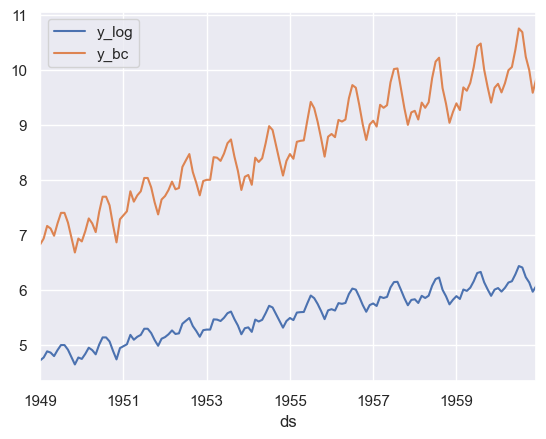

In [4]:
air_passengers = (
    df
    .set_index('ds')
    .asfreq("MS")
    .drop(columns='unique_id')
    .assign(
        y_bc=lambda df: df.y.pipe(boxcox)[0],
        y_bc_lambda=lambda df: df.y.pipe(boxcox)[1],
        y_log=lambda df: df.y.apply('log'),
    )
)

ax = air_passengers[['y_log', 'y_bc']].plot()

In [5]:
train_size = int(len(air_passengers) * 0.8)
air_passengers_train = air_passengers[:train_size]
air_passengers_test = air_passengers[train_size:]

In [6]:
air_passengers

,y,y_bc,y_bc_lambda,y_log
ds,,,,
1949-01-01,112,6.827488,0.148023,4.718499
1949-02-01,118,6.932820,0.148023,4.770685
1949-03-01,132,7.161889,0.148023,4.882802
1949-04-01,129,7.114609,0.148023,4.859812
1949-05-01,121,6.983785,0.148023,4.795791
...,...,...,...,...
1960-08-01,606,10.684045,0.148023,6.406880
1960-09-01,508,10.234569,0.148023,6.230481
1960-10-01,461,9.992156,0.148023,6.133398


In [7]:
from statsmodels.stats.descriptivestats import describe
describe(air_passengers.drop(columns='y_bc_lambda'))

,y,y_bc,y_log
nobs,144.000000,144.000000,144.000000
missing,0.000000,0.000000,0.000000
mean,280.298611,8.621253,5.542176
std_err,9.997193,0.083394,0.036788
upper_ci,299.892749,8.784701,5.614279
lower_ci,260.704473,8.457804,5.470073
std,119.966317,1.000725,0.441456
iqr,180.500000,1.577754,0.694532
iqr_normal,133.804850,1.169591,0.514858
mad,100.442901,0.852887,0.376343


### Seasonal Decomposition

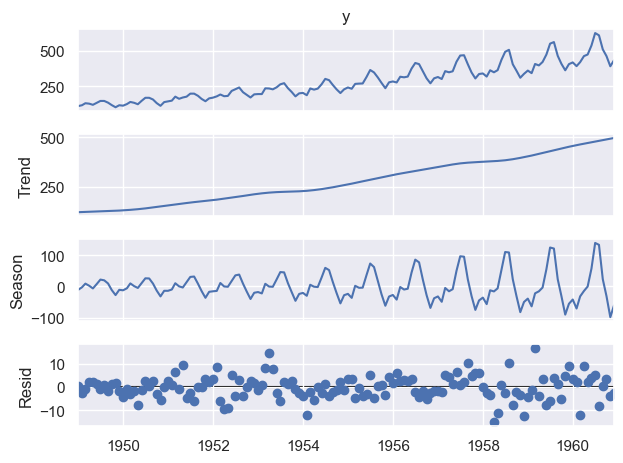

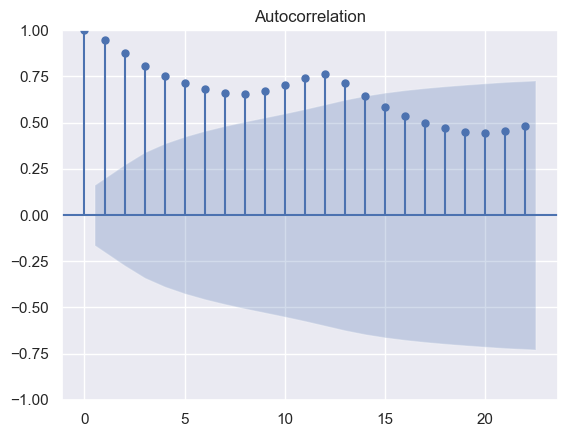

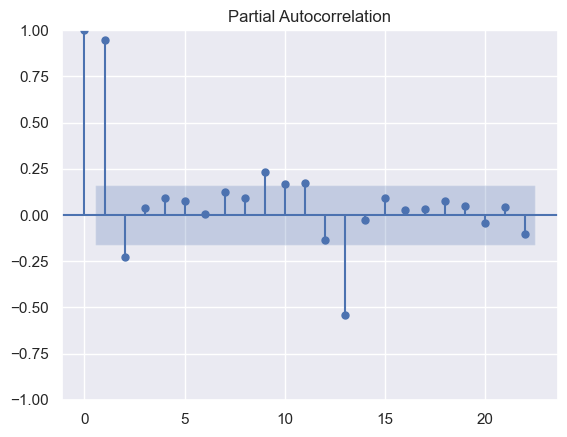

In [8]:
fig = sm.tsa.STL(air_passengers.y).fit().plot().tight_layout()
fig = sm.tsa.graphics.plot_acf(air_passengers.y)
fig = sm.tsa.graphics.plot_pacf(air_passengers.y)

# Baselines

### Naive

In [9]:
def shifted_frame(shift):

    sf = (
        air_passengers
        .assign(reference_ds=air_passengers.index - pd.DateOffset(months=shift))
        .join(
            air_passengers.shift(shift),
            on='ds',
            how='left',
            rsuffix='_previous'
        )
    )

    return sf

#### Previous Value

In [10]:
air_passengers_shifted = shifted_frame(1)
air_passengers_shifted

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1949-01-01,112,6.827488,0.148023,4.718499,1948-12-01,NaN,NaN,NaN,NaN
1949-02-01,118,6.932820,0.148023,4.770685,1949-01-01,112.0,6.827488,0.148023,4.718499
1949-03-01,132,7.161889,0.148023,4.882802,1949-02-01,118.0,6.932820,0.148023,4.770685
1949-04-01,129,7.114609,0.148023,4.859812,1949-03-01,132.0,7.161889,0.148023,4.882802
1949-05-01,121,6.983785,0.148023,4.795791,1949-04-01,129.0,7.114609,0.148023,4.859812
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,10.684045,0.148023,6.406880,1960-07-01,622.0,10.751448,0.148023,6.432940
1960-09-01,508,10.234569,0.148023,6.230481,1960-08-01,606.0,10.684045,0.148023,6.406880
1960-10-01,461,9.992156,0.148023,6.133398,1960-09-01,508.0,10.234569,0.148023,6.230481


In [11]:
air_passengers_shifted_to_test = air_passengers_shifted.loc[air_passengers_test.index]
air_passengers_shifted_to_test

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1958-08-01,505,10.219680,0.148023,6.224558,1958-07-01,491.0,10.149183,0.148023,6.196444
1958-09-01,404,9.668136,0.148023,6.001415,1958-08-01,505.0,10.219680,0.148023,6.224558
1958-10-01,359,9.383536,0.148023,5.883322,1958-09-01,404.0,9.668136,0.148023,6.001415
1958-11-01,310,9.036734,0.148023,5.736572,1958-10-01,359.0,9.383536,0.148023,5.883322
1958-12-01,337,9.233164,0.148023,5.820083,1958-11-01,310.0,9.036734,0.148023,5.736572
1959-01-01,360,9.390183,0.148023,5.886104,1958-12-01,337.0,9.233164,0.148023,5.820083
1959-02-01,342,9.268058,0.148023,5.834811,1959-01-01,360.0,9.390183,0.148023,5.886104
1959-03-01,406,9.680146,0.148023,6.006353,1959-02-01,342.0,9.268058,0.148023,5.834811
1959-04-01,396,9.619585,0.148023,5.981414,1959-03-01,406.0,9.680146,0.148023,6.006353


In [12]:
pd.Series({f.__name__: f(air_passengers_shifted_to_test.y, air_passengers_shifted_to_test.y_previous) for f in scores})

mean_absolute_error                 44.724138
mean_absolute_percentage_error       0.102636
max_error                          101.000000
mean_squared_error                2755.344828
root_mean_squared_error             52.491379
r2_score                             0.548636
dtype: float64

#### Previous Year's Value

In [13]:
air_passengers_shifted = shifted_frame(12)
air_passengers_shifted

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1949-01-01,112,6.827488,0.148023,4.718499,1948-01-01,NaN,NaN,NaN,NaN
1949-02-01,118,6.932820,0.148023,4.770685,1948-02-01,NaN,NaN,NaN,NaN
1949-03-01,132,7.161889,0.148023,4.882802,1948-03-01,NaN,NaN,NaN,NaN
1949-04-01,129,7.114609,0.148023,4.859812,1948-04-01,NaN,NaN,NaN,NaN
1949-05-01,121,6.983785,0.148023,4.795791,1948-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,10.684045,0.148023,6.406880,1959-08-01,559.0,10.476881,0.148023,6.326149
1960-09-01,508,10.234569,0.148023,6.230481,1959-09-01,463.0,10.002891,0.148023,6.137727
1960-10-01,461,9.992156,0.148023,6.133398,1959-10-01,407.0,9.686132,0.148023,6.008813


In [14]:
air_passengers_shifted_to_test = air_passengers_shifted.loc[air_passengers_test.index]
air_passengers_shifted_to_test

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1958-08-01,505,10.219680,0.148023,6.224558,1957-08-01,467.0,10.024244,0.148023,6.146329
1958-09-01,404,9.668136,0.148023,6.001415,1957-09-01,404.0,9.668136,0.148023,6.001415
1958-10-01,359,9.383536,0.148023,5.883322,1957-10-01,347.0,9.302521,0.148023,5.849325
1958-11-01,310,9.036734,0.148023,5.736572,1957-11-01,305.0,8.998769,0.148023,5.720312
1958-12-01,337,9.233164,0.148023,5.820083,1957-12-01,336.0,9.226132,0.148023,5.817111
1959-01-01,360,9.390183,0.148023,5.886104,1958-01-01,340.0,9.254153,0.148023,5.828946
1959-02-01,342,9.268058,0.148023,5.834811,1958-02-01,318.0,9.096408,0.148023,5.762051
1959-03-01,406,9.680146,0.148023,6.006353,1958-03-01,362.0,9.403429,0.148023,5.891644
1959-04-01,396,9.619585,0.148023,5.981414,1958-04-01,348.0,9.309362,0.148023,5.852202


In [15]:
pd.Series({f.__name__: f(air_passengers_shifted_to_test.y, air_passengers_shifted_to_test.y_previous) for f in scores})

mean_absolute_error                 41.310345
mean_absolute_percentage_error       0.091491
max_error                           74.000000
mean_squared_error                2123.517241
root_mean_squared_error             46.081637
r2_score                             0.652138
dtype: float64

### Prophet

This works well for the raw y's in a multiplicative seasonality mode.

In [16]:
y_train = air_passengers_train.y
y_test = air_passengers_test.y

In [17]:
Prophet?

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    scaling: str = 'absmax',
    holidays_mode=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
    flat trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changep

In [18]:
m = Prophet(
    seasonality_mode='multiplicative',
    # weekly_seasonality=False,
    # daily_seasonality=False,
)

In [19]:
(
    y_train
    .to_frame()
    .reset_index()
    .rename(columns={
        'y_bc': 'y',
    })
).pipe(m.fit)

22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] done processing


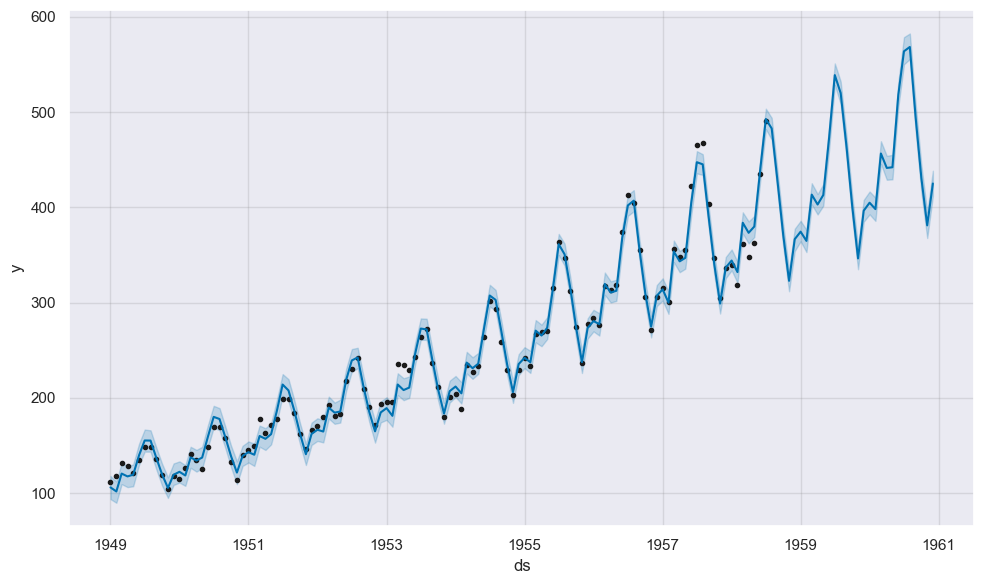

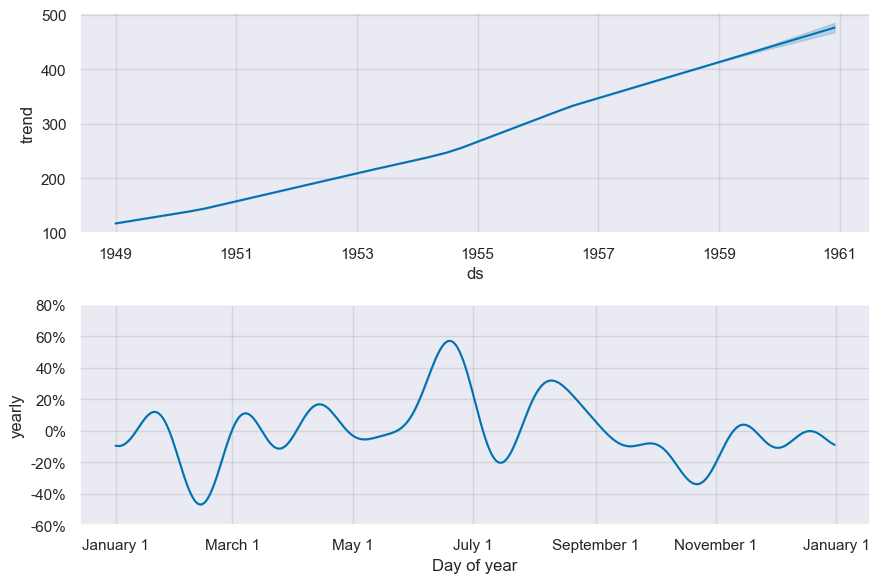

In [20]:
future = m.make_future_dataframe(periods=29, freq='MS')

forecast = m.predict(future)

fig = m.plot(forecast)
fig = m.plot_components(forecast)

In [21]:
prophet_predictions = m.predict(air_passengers_test.reset_index())
prophet_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1958-08-01,399.007169,472.274991,493.775709,399.006126,399.007866,0.209919,0.209919,0.209919,0.209919,0.209919,0.209919,0.0,0.0,0.0,482.766372
1,1958-09-01,401.807416,415.458015,437.969928,401.737714,401.860415,0.062712,0.062712,0.062712,0.062712,0.062712,0.062712,0.0,0.0,0.0,427.005728
2,1958-10-01,404.517332,359.555267,382.492804,404.336678,404.670317,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,0.0,0.0,0.0,371.037038
3,1958-11-01,407.317579,311.384865,333.723561,407.016241,407.616197,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,0.0,0.0,0.0,322.898457
4,1958-12-01,410.027496,355.351643,378.303436,409.561112,410.488604,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,0.0,0.0,0.0,366.600658
5,1959-01-01,412.827743,364.355352,386.357673,412.184601,413.466517,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,0.0,0.0,0.0,374.438214
6,1959-02-01,415.627990,352.769965,375.864923,414.780411,416.435488,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,0.0,0.0,0.0,364.772272
7,1959-03-01,418.157245,402.103043,424.234023,417.112445,419.163992,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,0.0,0.0,0.0,413.323371
8,1959-04-01,420.957493,391.449320,414.635162,419.674450,422.218530,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,0.0,0.0,0.0,402.951948
9,1959-05-01,423.667409,402.488381,424.838894,422.163654,425.204952,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,0.0,0.0,0.0,412.911648


In [22]:
prophet_predictions.join(y_test, on='ds')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
0,1958-08-01,399.007169,472.274991,493.775709,399.006126,399.007866,0.209919,0.209919,0.209919,0.209919,0.209919,0.209919,0.0,0.0,0.0,482.766372,505
1,1958-09-01,401.807416,415.458015,437.969928,401.737714,401.860415,0.062712,0.062712,0.062712,0.062712,0.062712,0.062712,0.0,0.0,0.0,427.005728,404
2,1958-10-01,404.517332,359.555267,382.492804,404.336678,404.670317,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,0.0,0.0,0.0,371.037038,359
3,1958-11-01,407.317579,311.384865,333.723561,407.016241,407.616197,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,0.0,0.0,0.0,322.898457,310
4,1958-12-01,410.027496,355.351643,378.303436,409.561112,410.488604,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,0.0,0.0,0.0,366.600658,337
5,1959-01-01,412.827743,364.355352,386.357673,412.184601,413.466517,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,0.0,0.0,0.0,374.438214,360
6,1959-02-01,415.627990,352.769965,375.864923,414.780411,416.435488,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,0.0,0.0,0.0,364.772272,342
7,1959-03-01,418.157245,402.103043,424.234023,417.112445,419.163992,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,0.0,0.0,0.0,413.323371,406
8,1959-04-01,420.957493,391.449320,414.635162,419.674450,422.218530,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,0.0,0.0,0.0,402.951948,396
9,1959-05-01,423.667409,402.488381,424.838894,422.163654,425.204952,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,0.0,0.0,0.0,412.911648,420


In [23]:
pd.Series({f.__name__: f(y_test, prophet_predictions.yhat) for f in scores})

mean_absolute_error                17.854876
mean_absolute_percentage_error      0.039812
max_error                          58.245090
mean_squared_error                492.582025
root_mean_squared_error            22.194189
r2_score                            0.919308
dtype: float64

# Exponential Smoothing

In [24]:
y_train = air_passengers_train.y
y_test = air_passengers_test.y

In [25]:
# sm.tsa.ETSModel
results = (
    air_passengers_train
    .y
    .pipe(
        sm.tsa.ExponentialSmoothing,
        trend='mul',
        seasonal='mul',
        seasonal_periods=12,
        # use_boxcox=True,
    )
    .fit()
)
results.summary()
# results.predict(air_passengers_test.index)

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Dep. Variable:,y,No. Observations:,115
Model:,ExponentialSmoothing,SSE,6062.038
Optimized:,True,AIC,487.960
Trend:,Multiplicative,BIC,531.879
Seasonal:,Multiplicative,AICC,495.085
Seasonal Periods:,12,Date:,"Thu, 28 Nov 2024"
Box-Cox:,False,Time:,22:17:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9999979,alpha,True
smoothing_trend,4.1932e-10,beta,True


<Axes: xlabel='ds'>

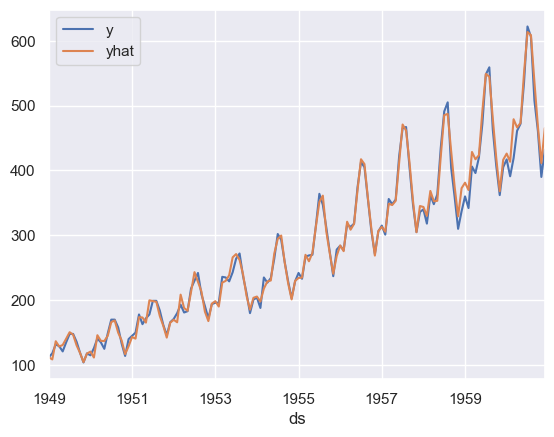

In [26]:
(
    air_passengers
    .assign(
        yhat=(results.predict(min(air_passengers_train.index), max(air_passengers_test.index))))
    .filter(['y', 'yhat'])
    .plot()
)

In [27]:
predictions = results.predict(min(air_passengers_test.index), max(air_passengers_test.index))
pd.Series({f.__name__: f(air_passengers_test.y, predictions) for f in scores})

mean_absolute_error                17.462699
mean_absolute_percentage_error      0.042565
max_error                          59.941083
mean_squared_error                455.269136
root_mean_squared_error            21.337037
r2_score                            0.925421
dtype: float64

# SARIMA

Building

Note that leaving out a seasonal MA component underpredicts the values. Try it and see the elevated orange dots in the plot.

In [28]:
y_train = air_passengers_train.y_bc
y_test = air_passengers_test.y_bc

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                       
Dep. Variable:                                  y_bc   No. Observations:                  115
Model:             ARIMA(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 109.015
Date:                               Thu, 28 Nov 2024   AIC                           -204.031
Time:                                       22:17:13   BIC                           -185.656
Sample:                                   01-01-1949   HQIC                          -196.590
                                        - 07-01-1958                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1851      0.290      0.638      0.524      -0.384       0.754
ma.L1      

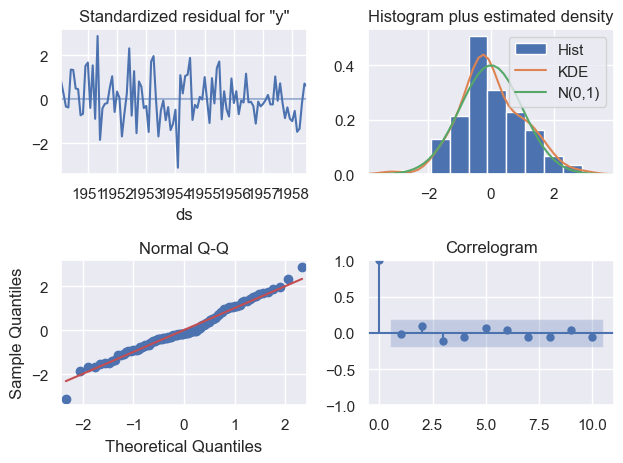

In [29]:
metaparameters = {
    "order": (1, 1, 1),
    "seasonal_order": (2, 1, 2, 12),
}

results = y_train.pipe(sm.tsa.ARIMA, **metaparameters).fit()

# To Read
print(results.summary())
fig = results.plot_diagnostics().tight_layout()

Validation

In [30]:
predictor = results.get_prediction(end=y_test.index[-1])
sf = predictor.summary_frame()
sf_ci80 = predictor.summary_frame(alpha=0.1)

# Just to be clear.
y_hat = sf["mean"].loc[y_test.index]

score_dictionary = {f.__name__: f(y_test, y_hat) for f in scores}
pd.Series(score_dictionary)

mean_absolute_error               0.060934
mean_absolute_percentage_error    0.006195
max_error                         0.145643
mean_squared_error                0.005504
root_mean_squared_error           0.074187
r2_score                          0.969751
dtype: float64

## Show me.

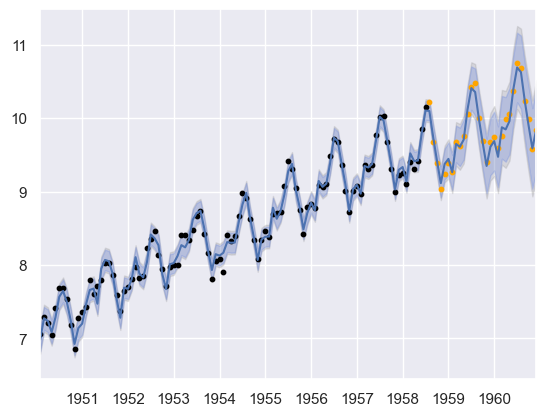

In [31]:
point_size = 10
starting_index = 13

sf[starting_index:]

ax = sf[starting_index:]["mean"].plot()

ax.set_xlim([min(y_train[starting_index:].index), max(y_test.index)])
# ax.set_xlim([min(y_test.index), max(y_test.index)])
# ax.set_xlim([min(y_train[starting_index:].index), max(y_train.index)])

ax.fill_between(
    sf[starting_index:].index,
    sf[starting_index:].mean_ci_lower,
    sf[starting_index:].mean_ci_upper,
    alpha=0.2,
    color="gray",
)

ax.fill_between(
    sf_ci80[starting_index:].index,
    sf_ci80[starting_index:].mean_ci_lower,
    sf_ci80[starting_index:].mean_ci_upper,
    alpha=0.2,
    color="royalblue",
)

ax.scatter(
    y_train.index, y_train, color="black", s=point_size,
)
ax.scatter(
    y_test.index, y_test, color="orange", s=point_size,
)

# Scratch

## Featuretools

In [32]:
import featuretools as ft

In [59]:
ft.dfs?

Signature:
ft.dfs(
    dataframes=None,
    relationships=None,
    entityset=None,
    target_dataframe_name=None,
    cutoff_time=None,
    instance_ids=None,
    agg_primitives=None,
    trans_primitives=None,
    groupby_trans_primitives=None,
    allowed_paths=None,
    max_depth=2,
    ignore_dataframes=None,
    ignore_columns=None,
    primitive_options=None,
    seed_features=None,
    drop_contains=None,
    drop_exact=None,
    where_primitives=None,
    max_features=-1,
    cutoff_time_in_index=False,
    save_progress=None,
    features_only=False,
    training_window=None,
    approximate=None,
    chunk_size=None,
    n_jobs=1,
    dask_kwargs=None,
    verbose=False,
    return_types=None,
    progress_callback=None,
    include_cutoff_time=True,
)
Docstring:
Calculates a feature matrix and features given a dictionary of dataframes
and a list of relationships.


Args:
    dataframes (dict[str -> tuple(DataFrame, str, str, dict[str -> str/Woodwork.LogicalType], dict[str-

In [55]:
dataframes = {
    'air_passengers': (df.reset_index(names='observation_id'), 'observation_id', 'ds')
}

In [52]:
feature_matrix_passengers, feature_defs = ft.dfs(
    dataframes=dataframes,
    target_dataframe_name='air_passengers',
)

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


In [53]:
feature_matrix_passengers

,observation_id,unique_id,y,DAY(ds),MONTH(ds),WEEKDAY(ds),YEAR(ds)
ds,,,,,,,
1949-01-01,0,AirPassengers,112,1,1,5,1949
1949-02-01,1,AirPassengers,118,1,2,1,1949
1949-03-01,2,AirPassengers,132,1,3,1,1949
1949-04-01,3,AirPassengers,129,1,4,4,1949
1949-05-01,4,AirPassengers,121,1,5,6,1949
...,...,...,...,...,...,...,...
1960-08-01,139,AirPassengers,606,1,8,0,1960
1960-09-01,140,AirPassengers,508,1,9,3,1960
1960-10-01,141,AirPassengers,461,1,10,5,1960


In [54]:
feature_defs

[<Feature: observation_id>,
 <Feature: unique_id>,
 <Feature: y>,
 <Feature: DAY(ds)>,
 <Feature: MONTH(ds)>,
 <Feature: WEEKDAY(ds)>,
 <Feature: YEAR(ds)>]

In [46]:
feature = feature_defs[3]
feature

<Feature: MONTH(ds)>

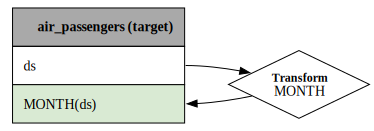

In [49]:
ft.graph_feature(feature)

In [50]:
ft.describe_feature(feature)

'The month of the "ds".'

## Interpolation

                     y      y_bc  y_bc_lambda     y_log
ds                                                     
1949-01-01  112.000000  6.827488     0.148023  4.718499
1949-01-02  112.193548  6.830886     0.148023  4.720182
1949-01-03  112.387097  6.834284     0.148023  4.721866
1949-01-04  112.580645  6.837682     0.148023  4.723549
1949-01-05  112.774194  6.841079     0.148023  4.725233
...                ...       ...          ...       ...
1960-11-27  426.400000  9.798625     0.148023  6.054788
1960-11-28  427.800000  9.806933     0.148023  6.058198
1960-11-29  429.200000  9.815241     0.148023  6.061607
1960-11-30  430.600000  9.823549     0.148023  6.065016
1960-12-01  432.000000  9.831857     0.148023  6.068426

[4353 rows x 4 columns]


<Axes: xlabel='ds'>

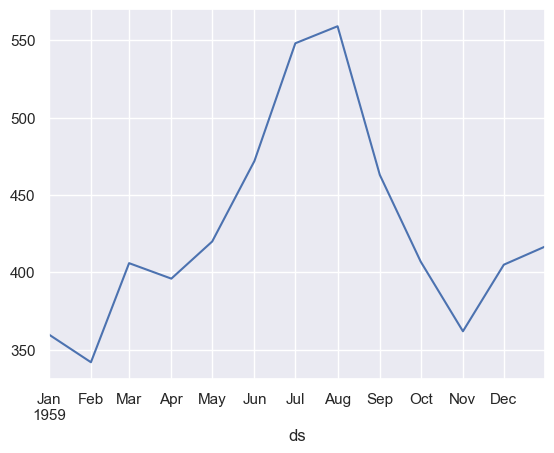

In [150]:
poly_order = 1

rsdf = (
    air_passengers
    .resample('1D')
    # .interpolate()
    .interpolate('polynomial', order=poly_order)
)
print(rsdf)

rsdf.loc['1959'].y.plot()

## Prophet with Additional Regressors

In [272]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [280]:
prophet_exog_train

,ds,y,MONTH(ds)
0,1949-01-01,112,1
1,1949-02-01,118,2
2,1949-03-01,132,3
3,1949-04-01,129,4
4,1949-05-01,121,5
...,...,...,...
110,1958-03-01,362,3
111,1958-04-01,348,4
112,1958-05-01,363,5
113,1958-06-01,435,6


In [367]:
ct = make_column_transformer(
    (OneHotEncoder(), ['MONTH(ds)']),
    remainder='drop',
)

In [368]:
pipe = make_pipeline(
    ct,
)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['MONTH(ds)'])]))])

In [400]:
enc = OneHotEncoder(drop='first', sparse_output=False)
feature = enc.fit_transform(prophet_exog_train[['MONTH(ds)']])
# pd.DataFrame.sparse.from_spmatrix(feature)
feature

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [395]:
OneHotEncoder?

Init signature:
OneHotEncoder(
    *,
    categories='auto',
    drop=None,
    sparse_output=True,
    dtype=<class 'numpy.float64'>,
    handle_unknown='error',
    min_frequency=None,
    max_categories=None,
    feature_name_combiner='concat',
)
Docstring:     
Encode categorical features as a one-hot numeric array.

The input to this transformer should be an array-like of integers or
strings, denoting the values taken on by categorical (discrete) features.
The features are encoded using a one-hot (aka 'one-of-K' or 'dummy')
encoding scheme. This creates a binary column for each category and
returns a sparse matrix or dense array (depending on the ``sparse_output``
parameter).

By default, the encoder derives the categories based on the unique values
in each feature. Alternatively, you can also specify the `categories`
manually.

This encoding is needed for feeding categorical data to many scikit-learn
estimators, notably linear models and SVMs with the standard kernels.

Note: a o

In [375]:
pd.DataFrame.sparse.from_spmatrix(pipe.fit_transform(prophet_exog_train, columns=pipe.get_feature_names_out()))

ValueError: Pipeline.fit does not accept the columns parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

In [369]:
feature_matrix_passengers

,observation_id,unique_id,y,DAY(ds),MONTH(ds),WEEKDAY(ds),YEAR(ds)
ds,,,,,,,
1949-01-01,0,AirPassengers,112,1,1,5,1949
1949-02-01,1,AirPassengers,118,1,2,1,1949
1949-03-01,2,AirPassengers,132,1,3,1,1949
1949-04-01,3,AirPassengers,129,1,4,4,1949
1949-05-01,4,AirPassengers,121,1,5,6,1949
...,...,...,...,...,...,...,...
1960-08-01,139,AirPassengers,606,1,8,0,1960
1960-09-01,140,AirPassengers,508,1,9,3,1960
1960-10-01,141,AirPassengers,461,1,10,5,1960


In [370]:
m = Prophet(
    seasonality_mode='multiplicative'
)

In [216]:
prophet_exog = (
    feature_matrix_passengers
    # .reset_index()
    .filter(['ds', 'y', 'MONTH(ds)'])
)
prophet_exog

,y,MONTH(ds)
ds,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5
...,...,...
1960-08-01,606,8
1960-09-01,508,9
1960-10-01,461,10


In [217]:
prophet_exog_train = prophet_exog.loc[air_passengers_train.index].reset_index()
prophet_exog_test = prophet_exog.loc[air_passengers_test.index].reset_index()

In [218]:
m.add_regressor('MONTH(ds)')

In [219]:
m.fit(prophet_exog_train)

22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing


In [220]:
forecast = m.predict(prophet_exog_test.drop(columns='y'))
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,MONTH(ds),MONTH(ds)_lower,MONTH(ds)_upper,extra_regressors_multiplicative,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1958-08-01,399.306178,470.825568,494.142456,399.288880,399.317325,-0.008509,-0.008509,-0.008509,-0.008509,...,0.209203,0.209203,0.209203,0.217712,0.217712,0.217712,0.0,0.0,0.0,482.842180
1,1958-09-01,402.103604,415.915566,437.802908,402.023088,402.181627,-0.013659,-0.013659,-0.013659,-0.013659,...,0.060852,0.060852,0.060852,0.074511,0.074511,0.074511,0.0,0.0,0.0,426.572377
2,1958-10-01,404.810791,358.844349,381.320464,404.619062,404.990001,-0.018809,-0.018809,-0.018809,-0.018809,...,-0.084243,-0.084243,-0.084243,-0.065434,-0.065434,-0.065434,0.0,0.0,0.0,370.708170
3,1958-11-01,407.608217,311.656039,334.265778,407.288468,407.916218,-0.023959,-0.023959,-0.023959,-0.023959,...,-0.207383,-0.207383,-0.207383,-0.183423,-0.183423,-0.183423,0.0,0.0,0.0,323.077310
4,1958-12-01,410.315403,353.930652,377.590258,409.852696,410.791853,-0.029109,-0.029109,-0.029109,-0.029109,...,-0.107067,-0.107067,-0.107067,-0.077957,-0.077957,-0.077957,0.0,0.0,0.0,366.384343
5,1959-01-01,413.112829,362.744775,385.320906,412.494599,413.743957,0.027542,0.027542,0.027542,0.027542,...,-0.094028,-0.094028,-0.094028,-0.121570,-0.121570,-0.121570,0.0,0.0,0.0,374.268581
6,1959-02-01,415.910255,353.180957,376.294288,415.103717,416.732068,0.022392,0.022392,0.022392,0.022392,...,-0.123427,-0.123427,-0.123427,-0.145818,-0.145818,-0.145818,0.0,0.0,0.0,364.575907
7,1959-03-01,418.436962,401.572525,424.043421,417.444329,419.445123,0.017242,0.017242,0.017242,0.017242,...,-0.012579,-0.012579,-0.012579,-0.029821,-0.029821,-0.029821,0.0,0.0,0.0,413.173422
8,1959-04-01,421.234388,390.886724,414.891288,420.050047,422.518681,0.012092,0.012092,0.012092,0.012092,...,-0.043345,-0.043345,-0.043345,-0.055437,-0.055437,-0.055437,0.0,0.0,0.0,402.975801
9,1959-05-01,423.941575,400.964769,424.148002,422.546624,425.460417,0.006941,0.006941,0.006941,0.006941,...,-0.027004,-0.027004,-0.027004,-0.033945,-0.033945,-0.033945,0.0,0.0,0.0,412.493502


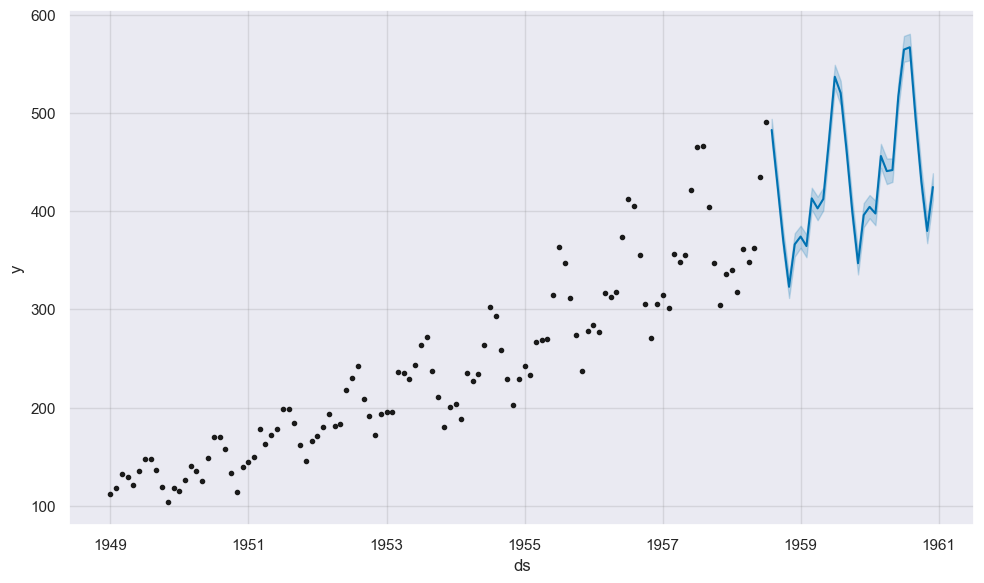

In [226]:
fig = m.plot(forecast)

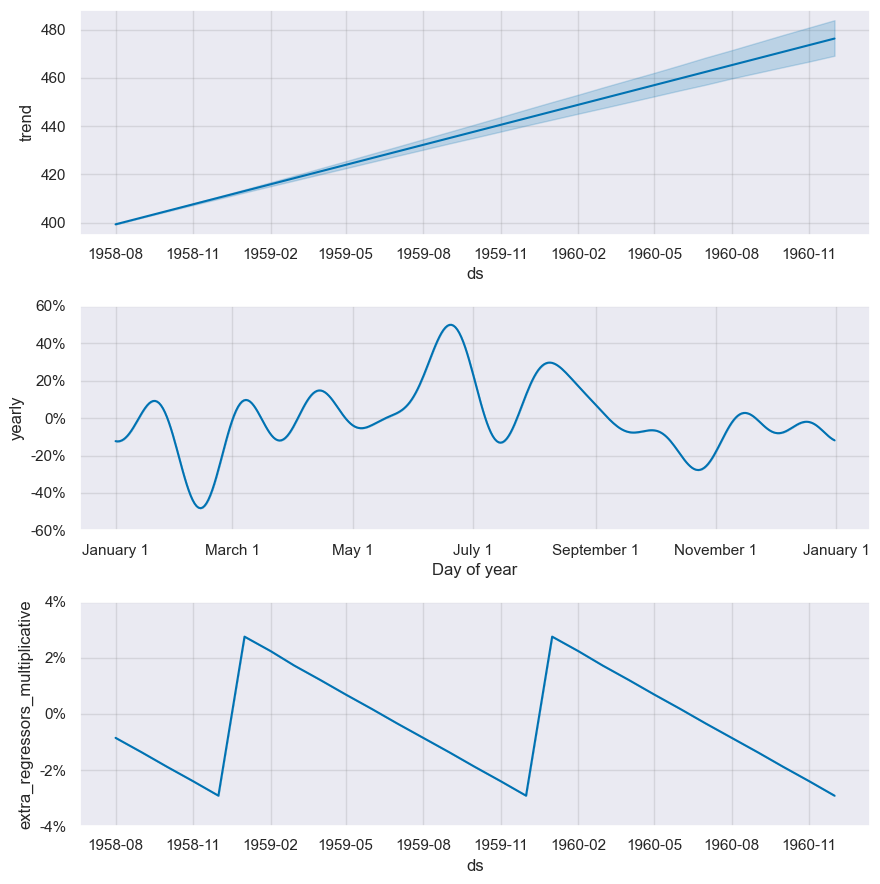

In [222]:
fig = m.plot_components(forecast)

In [223]:
pd.Series({f.__name__: f(prophet_exog_test.y, forecast.yhat) for f in scores})

mean_absolute_error                17.987318
mean_absolute_percentage_error      0.040061
max_error                          57.265560
mean_squared_error                492.439675
root_mean_squared_error            22.190982
r2_score                            0.919332
dtype: float64

# Nixtla

## StatsForecast

In [239]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF

df = AirPassengersDF
df_train = df[:train_size]
df_test = df[train_size:]

In [259]:
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS',
)
sf

StatsForecast(models=[AutoARIMA])

In [260]:
sf.fit(df_train)

StatsForecast(models=[AutoARIMA])

In [261]:
len(df_test)

29

In [262]:
sf_predictions = sf.predict(h=29, level=[95])
sf_predictions

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1.0,1958-08-01,490.318247,471.354413,509.282082
1.0,1958-09-01,427.871463,403.660225,452.082700
1.0,1958-10-01,370.757341,341.814534,399.700148
1.0,1958-11-01,328.780883,295.857705,361.704060
1.0,1958-12-01,359.776026,323.289533,396.262519
1.0,1959-01-01,363.777028,324.048324,403.505732
1.0,1959-02-01,341.776821,299.050698,384.502945
1.0,1959-03-01,385.776864,340.250346,431.303382
1.0,1959-04-01,371.776855,323.612469,419.941241


In [263]:
pd.Series({f.__name__: f(df_test.y, sf_predictions.AutoARIMA) for f in scores})

mean_absolute_error                 28.567120
mean_absolute_percentage_error       0.061287
max_error                           83.446287
mean_squared_error                1232.215302
root_mean_squared_error             35.102924
r2_score                             0.798146
dtype: float64

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsforecast/core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


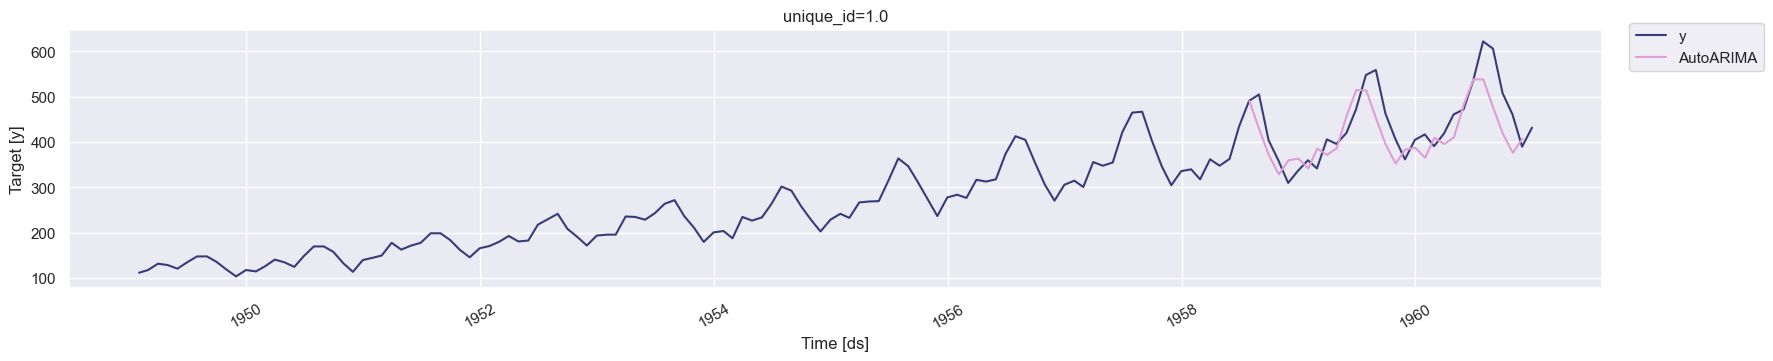

In [264]:
sf.plot(df, forecasts_df=sf_predictions)